#  TP : Reconnaissance de chiffres

<center><img src=https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png?download width=600></center>

Dans ce TP, nous voulons reconnaître des chiffres manuscrits en utilisant l'algorithme des $k$-moyennes.

**Remarque** : le jeu de données utilisé est normalement utilisé pour de la classification supervisée (puisque les classes sont déjà connues) mais il est quand même intéressant d'utiliser l'algorithme des $k$-moyennes (qui est non-supervisé) pour voir s'il arrive à trouver les classes correspondants aux chiffres.

Commençons par charger les données :

In [2]:
import numpy as np
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt

digits = load_digits()
digits_matrix = digits.images[1000:] # utilisation d'une partie seulement pour accélérer les calculs
digits_matrix.shape

(797, 8, 8)

`digits_matrix` est un tableau `numpy` de taille $797\times 8\times 8$, c'est-à-dire $797$ matrices de taille $8\times 8$.

In [3]:
digits_matrix[0] # la 1ère matrice

array([[ 0.,  0.,  1., 14.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 16.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 14., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  3., 14.,  6.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8., 12.,  0.,  0.],
       [ 0.,  0., 10., 14., 13., 16.,  8.,  3.],
       [ 0.,  0.,  2., 11., 12., 15., 16., 15.]])

Chacune de ces matrices est en fait une image de $8\times 8$ pixels, représentant un chiffre manuscrit.  
Chaque élément de la matrice représente un niveau de gris entre $0$ (blanc) et $16$ (noir).  
Par exemple, affichons l'image correspondant à la matrice ci-dessus :

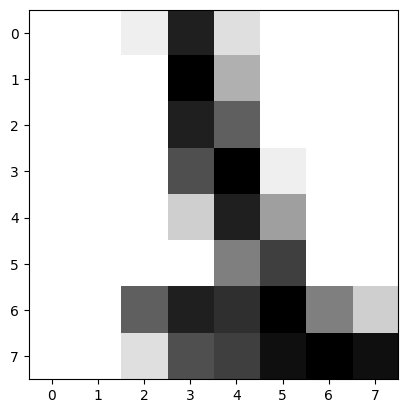

In [4]:
plt.imshow(digits_matrix[0], cmap=plt.cm.gray_r)
plt.show() # ça ressemble à un 1

## Redimensionner les images

Pour appliquer l'algorithme des $k$-moyennes, il faut que les données soient des vecteurs. On transforme donc une matrice en vecteur en concaténant les lignes de la matrice :  
$$
\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{pmatrix}
\longrightarrow
\begin{pmatrix}
1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9
\end{pmatrix}
$$

Écrire une fonction `to_vector(m)` qui prend en argument une matrice `m` et renvoie le vecteur correspondant, sous forme de liste.

In [5]:
def to_vector(m):
    vector = []
    for l in m:
        vector += list(l)
    return vector

In [6]:
assert len(to_vector(digits_matrix[0])) == 64 # les images 8*8 sont transformées en vecteur 64

Écrire une fonction `to_matrix(v)` qui prend en argument un vecteur `v` et renvoie la matrice correspondante, sous forme de liste de listes.

In [7]:
def to_matrix(v):
    matrix = []
    n = int(len(v) ** 0.5)
    for i in range(n):
        matrix.append(v[n * i : n * i + n])
    return matrix

In [8]:
assert (to_matrix(to_vector(digits_matrix[0])) == digits_matrix[0]).all() 
# to_matrix et to_vector sont inverses l'une de l'autre

Définir une liste `X` contenant les vecteurs correspondant aux images dans `digits_matrix`. Cette variable `X` sera utilisée dans toute la suite.

In [9]:
X = [to_vector(x) for x in digits_matrix]

## Algorithmes des $k$-moyennes

Écrire une fonction `d(u, v)` qui prend en argument deux vecteurs `u` et `v` et renvoie la distance euclidienne entre ces deux vecteurs.

In [10]:
def d(x, y):
    # assert x == y, "vector must be of the same dimension"
    dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i])**2
    return dist ** 0.5

In [11]:
d([1, 2, 3], [4, 5, 6])

5.196152422706632

Comme dans le cours, nous utilisons une liste `centres` pour stocker les centres des classes. `centres[i]` est le centre de la classe $i$.

Écrire une fonction `centres_aléatoires(X, k)` qui prend en argument une liste de vecteurs `X` et un entier `k` et renvoie une liste de `k` vecteurs aléatoires choisis dans `X`.  
On utilisera `random.sample` dont [on pourra consulter la documentation ici](https://docs.python.org/3/library/random.html). On pourra préalablement utiliser `random.seed(0)` pour avoir les mêmes résultats que le corrigé du TP.

In [12]:
import random as rd 
rd.seed(0)

def centres_aleatoires(set, number:int):
    return [X[i] for i in rd.sample(range(len(X)), number)]

In [13]:
centres = centres_aleatoires(X, 10)
assert len(centres) == 10 and len(centres[0]) == 64

Écrire une fonction `plus_proche(x, centres)` qui prend en argument un vecteur `x` et une liste de vecteurs `centres` et renvoie l'indice du centre le plus proche de `x`.

In [14]:
def plus_proche(x, centres):
    return min(range(len(centres)), key = lambda i: d(x, centres[i]))

In [15]:
plus_proche([1, 2], [[4, 5], [2, 3], [4, 0]])

1

Contrairement à ce qui a été fait dans le cours, on utilise dans la suite une liste `classes` telle que `classes[i]` est le numéro de classe de `X[i]` (dans le cours, `classes[i]` était la liste des vecteurs de la classe $i$).

Écrire une fonction `calculer_classes(X, centres)` qui renvoie la liste `classes` correspondant à `X` et à `centres`.

In [16]:
def calculer_classes(set, centers):
    classes = [0] * len(set)
    for i in range(len(classes)):
        classes[i] = plus_proche(X[i], centers) 
    return classes

In [17]:
classes = calculer_classes(X, centres_aleatoires(X, 10))
assert len(classes) == len(X) and max(classes) < 10 and min(classes) >= 0

Écrire une fonction `centre(X, classes, i)` qui renvoie le centre de la classe $i$.

In [18]:
def centre(set, classes, i):
    center = [0] * len(set[0])
    count = 0
    for j in range(len(set)):
        if classes[j] == i:
            count += 1
            for k in range(len(center)):
                center[k] += X[j][k]
    if count != 0:
        for k in range(len(center)):
            center[k] *= (1 / count)
    return center

In [19]:
assert len(centre(X, classes, 0)) == 64

Écrire une fonction `calculer_centres(X, classes, k)` qui renvoie la liste `centres` correspondant à `X` et à `classes`.

In [20]:
def calculer_centres(X, classes, k):
    centres = [0] * k
    for i in range(k):
        centres[i] = centre(X, classes, i)
    return centres

In [21]:
classes = calculer_classes(X, centres_aleatoires(X, 10))
assert len(calculer_centres(X, classes, 10)) == 10 and len(calculer_centres(X, classes, 10)[0]) == 64

Écrire une fonction `kmeans(X, centres, k)` qui, à partir de centres initiaux donnés en argument, applique l'algorithme des $k$-moyennes et renvoie un couple correspondant à la liste `(centres, classes)` obtenue à la fin de l'algorithme.

In [22]:
def kmeans(X, centres, k):
    classes = calculer_classes(X, centres)
    centres_temp = calculer_centres(X, classes, k)
    if centres_temp == centres:
        return centres, classes
    else:
        return kmeans(X, centres_temp, k)

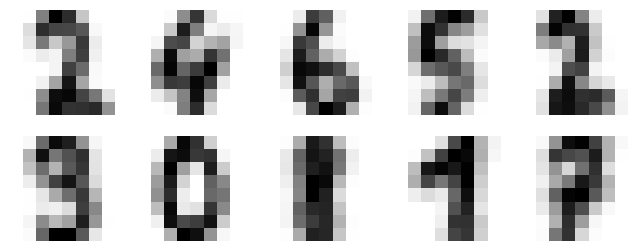

In [23]:
k = 10
centres, classes = kmeans(X, centres_aleatoires(X, k), k) # ceci prend quelques secondes
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for ax, center in zip(axes.ravel(), centres):
    ax.matshow(np.array(to_matrix(center)).reshape((8, 8)), cmap=plt.cm.gray_r)
    ax.axis('off')
plt.show()

## Calcul de l'inertie

Dans cette partie, on réutilise les listes `centres` et `classes` obtenues précédemment par un appel à `kmeans`.

Écrire une fonction `inertie(X, centres, classes)` qui renvoie l'inertie de la partition définie par `classes`. On rappelle que l'inertie d'une partition est la somme des distances au carré des points à leur centre de classe.

In [24]:
def inertie(X, centres, classes):
    inertie = 0
    for i in range(len(X)):
        inertie += d(X[i], centres[classes[i]]) ** 2
    return inertie

In [25]:
inertie(X, centres, classes)

497072.3036274611

Réécrire la fonction `kmeans` précédente de façon à ce qu'elle renvoie aussi la liste des inerties obtenues à chaque itération de l'algorithme. Utiliser le code ci-dessous pour afficher aussi l'évolution de l'inertie au cours des itérations. Commenter.

In [26]:
def kmeans(X, centres, k, inerties=[]):
    classes = calculer_classes(X, centres)
    centres_temp = calculer_centres(X, classes, k)
    inerties.append(inertie(X, centres, classes))
    if centres_temp == centres:
        return centres, classes, inerties
    else:
        return kmeans(X, centres_temp, k, inerties)

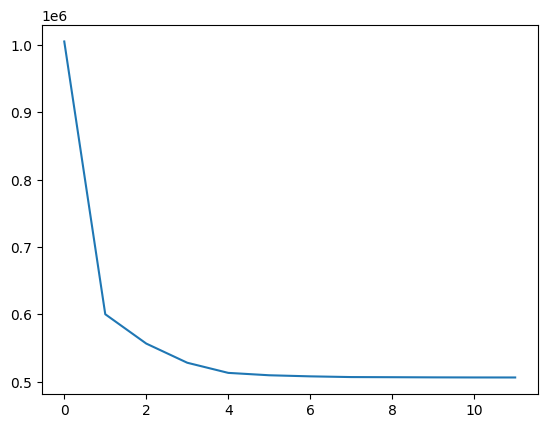

In [27]:
centres, classes, inerties = kmeans(X, centres_aleatoires(X, k), k) # ceci prend quelques secondes
plt.plot(inerties)
plt.show()

## Classification de nouvelles images

Exécuter le code suivant pour afficher le centre de chaque classe. Il s'agit donc, pour chaque classe, de l'image obtenue en faisant la moyenne (pixel par pixel) des images de la classe.

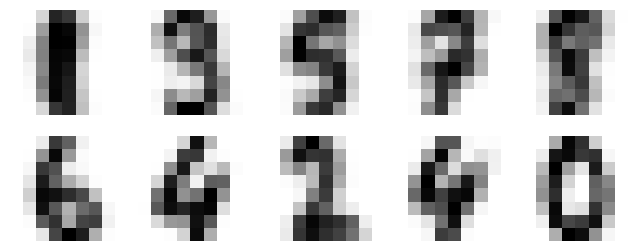

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for ax, center in zip(axes.ravel(), centres):
    ax.matshow(np.array(to_matrix(center)).reshape((8, 8)), cmap=plt.cm.gray_r)
    ax.axis('off')
plt.show()

Sur l'image ci-dessus, les classes sont représentés dans l'ordre, de gauche à droite et de haut en bas. Par exemple, l'image en haut à gauche correspond à la classe $0$, celle juste à droite à la classe $1$...

Définir une liste `classe_to_chiffre` telle que `classe_to_chiffre[i]` est le chiffre que vous pouvez lire pour le centre de la classe $i$.

In [29]:
classe_to_chiffre = [1, 9, 5, 7, 8, 6, 4, 2, 4, 0]  

Exécuter le code suivant pour stocker dans `X_test` les vecteurs correspondant aux images que l'on va essayer de classifier, en utilisant le résultat de `kmeans`.

In [30]:
X_test = list(map(to_vector, digits.images[:500]))

Exercice
  
1. Écrire une fonction `predict(x, centres, classe_to_chiffre)` qui renvoie le chiffre prédit pour l'image `x`. Il faut donc trouver la classe `i` la plus proche de `x` et renvoyer `classe_to_chiffre[i]`.  
2. Exécuter le code suivant pour afficher des images de `X_test` et les chiffres prédits.


In [31]:
def predict(x, centres, classe_to_chiffre):
    return classe_to_chiffre[plus_proche(x, centres)]

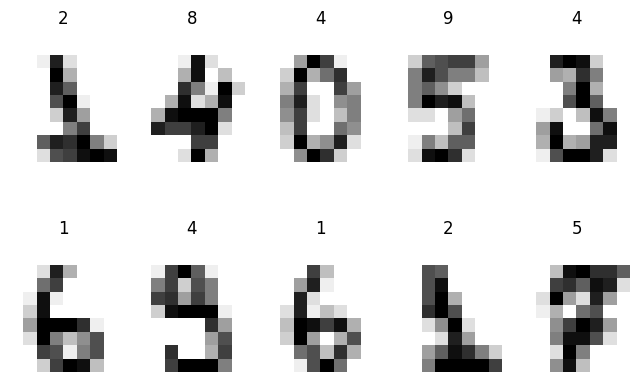

In [32]:
centres, classes, inerties = kmeans(X_test, centres_aleatoires(X_test, 10), 10)
fig, axes = plt.subplots(2, 5, figsize=(8, 5))
for i, ax in enumerate(axes.ravel()):
    ax.matshow(np.array(to_matrix(X[i])).reshape((8, 8)), cmap=plt.cm.gray_r)
    ax.set_title(predict(X[i], centres, classe_to_chiffre))
    ax.axis('off')
plt.show()

Écrire une fonction `precision(centres)` qui renvoie la précision de cet algorithme de classification, sur les données de `X_test`. Pour cela, on compte la proportion de classe prédite pour `X_test[i]` égale à `digits.target[i]`.

In [33]:
def precision(centres):
    count = 0
    for i in range(len(X_test)):
        if plus_proche(X_test[i], centres) == digits.target[i]:
            count += 1
    return count / len(X_test)

In [34]:
precision(centres)

0.112

## Avec les $k$ plus proches voisins

Implémenter l'algorithme des $k$ plus proches voisins et comparer la précision obtenue avec celle des $k$-moyennes`. Quel algorithme de classification semble le plus adapté ici ?